In [91]:
import numpy as np
import scipy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Callable, Union, Iterable

import torch
from torch import nn
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.utils.cholesky import psd_safe_cholesky

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [72]:
def inv_softplus(x):
    return torch.log(torch.exp(x) - 1)

In [4]:
np.random.seed(123)

In [39]:
def m(x, theta):
    delta, rep = x.T
    alpha, beta = theta
    return np.exp(-alpha*(1-beta)**rep*delta)

In [56]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.unc_alpha = nn.Parameter(torch.zeros(1))
        self.unc_beta = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        
        delta, rep = x.T
        
        alpha = nn.functional.softplus(self.unc_alpha)
        beta = torch.sigmoid(self.unc_beta)
        
        log_p = -alpha*(1-beta)**rep*delta
        p = log_p.exp()
        return p

In [57]:
delta = np.random.uniform(0, 2**5, 1000)
rep = np.random.randint(0, 10, size=1000)

x = np.concatenate((delta[None, :], rep[None, :]), axis=0).T

y = (m(x, (0.05, 0.2)) > np.random.random(x.shape[0])).astype(int)

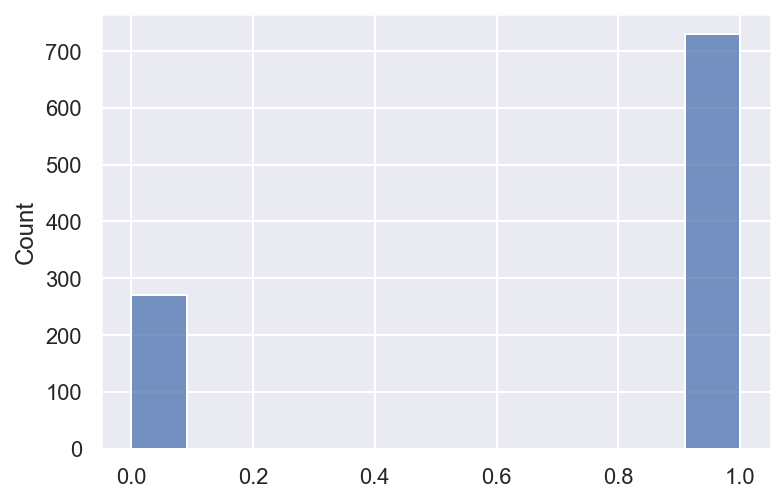

In [58]:
sns.histplot(y);

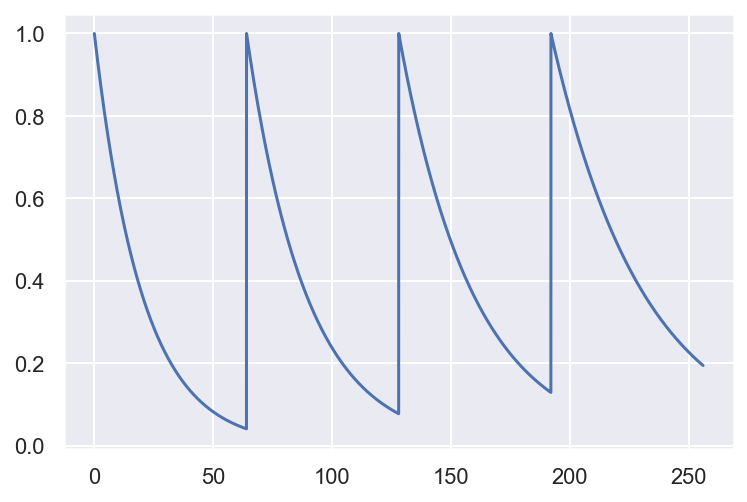

In [59]:
x_plot = np.linspace(0, 2**8, 8000)

presentations = np.arange(2000, 8000, 2000)

delta = x_plot.copy()
rep = np.zeros(x_plot.shape)

for pres in presentations:

    delta[pres:] = x_plot[pres:] - x_plot[pres]
    rep[pres:] += 1

x_input = np.concatenate((delta[None, :], rep[None, :]), axis=0).T

y_plot = m(x_input, (0.05, 0.2))
plt.plot(x_plot, y_plot);

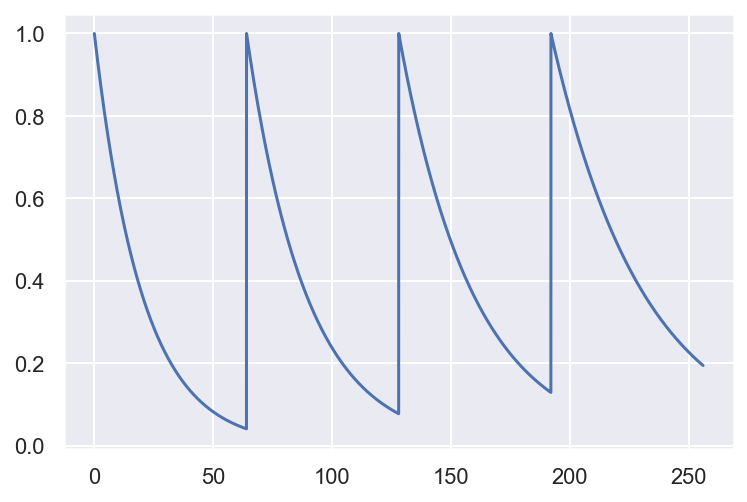

In [60]:
with torch.no_grad():
    ref_model = Model()
    ref_model.unc_alpha[0] = inv_softplus(torch.tensor([0.05]))
    ref_model.unc_beta[0] = scipy.special.logit(0.2)
    
    y_plot_model = ref_model(torch.from_numpy(x_input)).numpy()

plt.plot(x_plot, y_plot_model);

In [61]:
def obj(theta):
    p_suc = m(x, theta)
    p = p_suc**y*(1-p_suc)**(1-y)
    logp = np.log(p+1e-07)
    return - logp.sum()

scipy.optimize.minimize(obj, x0=(0, 0.5), bounds=((0, np.inf), (0, 1)))

      fun: 463.8623599720801
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.68434189e-06, -5.68434189e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 126
      nit: 26
     njev: 42
   status: 0
  success: True
        x: array([0.05143844, 0.20944292])

In [62]:
train_x = torch.from_numpy(x.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))

In [63]:
learning_rate = 0.01
epochs=1000


model = Model()


# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

hist_loss = []

pbar = tqdm(total=epochs)

for i in range(epochs):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    p = model(train_x)
    
    # Calc loss and backprop gradients
    # p = p_suc**train_y*(1-p_suc)**(1-train_y)
    logp = dist.Bernoulli(probs=p).log_prob(train_y)
    loss = -logp.sum()
    loss.backward()
    
    optimizer.step()

    hist_loss.append(loss.item())

    if pbar is not None:
        pbar.set_postfix(loss=loss.item())
        pbar.update()

if pbar is not None:
    pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

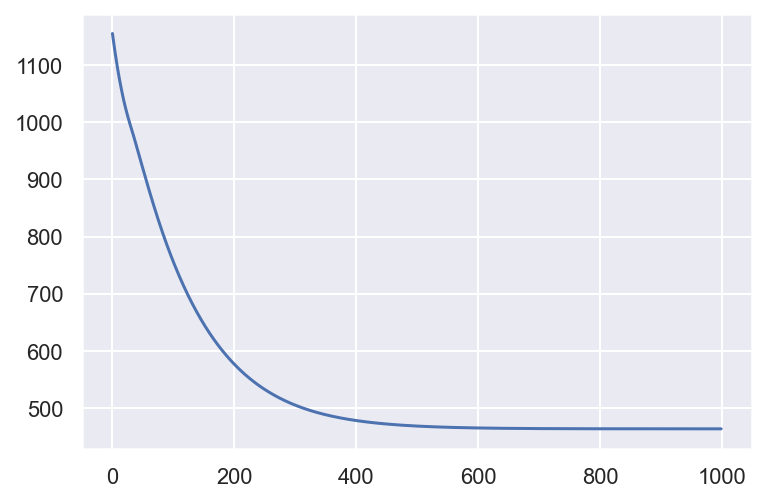

In [64]:
plt.plot(hist_loss);

In [83]:
opt = {k: torch.tensor([v]) for k, v in model.named_parameters()}
print(opt)
print("alpha", nn.functional.softplus(opt["unc_alpha"]).item())
print("beta", torch.sigmoid(opt["unc_beta"]).item())

{'unc_alpha': tensor([-2.9314]), 'unc_beta': tensor([-1.3184])}
alpha 0.05195179209113121
beta 0.21107766032218933


In [92]:
class GPClassificationModel(ApproximateGP):

    def __init__(self, inducing_points, learn_inducing_locations):
        
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(0))
        
        variational_strategy = VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=learn_inducing_locations)
        
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = \
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


def safe_log(x): return torch.log(x + 1e-07)


def identity(x): return x


class DiscrepancyModel:

    def __init__(
            self,
            x: np.ndarray,
            y: np.ndarray,
            m: Callable,
            theta: Union[int, float, list],
            h: Union[str, Callable] = None,
            learn_inducing_locations: bool = False,
            jitter: Union[int, float] = 1e-07,
            n_samples: int = 40,
            n_inducing_points: int = 50,
            cholesky_max_tries: int = 1000):

        if h is None or h == "sigmoid" or h == torch.sigmoid:
            h = torch.sigmoid
            h_inv = torch.logit

        else:
            raise ValueError

        self.train_x = torch.from_numpy(x.astype(np.float32))
        self.train_y = torch.from_numpy(y.astype(np.float32))

        self.m = m
        self.theta = theta

        self.h = h
        self.h_inv = h_inv

        self.n_samples = n_samples

        self.n_x = self.train_x.size(0)
        self.n_y = self.train_y.size(0)

        self.jitter = jitter

        self.h_inv_m = self.h_inv(self.m(self.train_x, self.theta))
        
        inducing_delta = np.linspace(x[:, 0].min(), x[:, 0].max(), n_inducing_points)
        inducing_rep = np.linspace(x[:, 1].min(), x[:, 1].max(), n_inducing_points)
        
        inducing_points = np.concatenate((inducing_delta[None, :], inducing_rep[None, :]), axis=0).T
        inducing_points = torch.from_numpy(inducing_points.astype(np.float32))

        self.r_model = GPClassificationModel(
            inducing_points=inducing_points,
            learn_inducing_locations=learn_inducing_locations)

        self.cholesky_max_tries = cholesky_max_tries

        self.hist_loss = None

    def expected_log_prob(
            self, 
            observations: torch.Tensor, 
            function_dist: gpytorch.distributions.MultivariateNormal):

        L = psd_safe_cholesky(function_dist.covariance_matrix,
                              max_tries=self.cholesky_max_tries)

        gp_mean = function_dist.loc
        eta = torch.randn(self.n_x, self.n_samples)
        L_eta = L @ eta
        r = gp_mean + L_eta.T

        f = self.h(self.h_inv_m + r)
        log_prob = dist.Bernoulli(probs=f).log_prob(
            observations).mean(0)
        return log_prob

    def train(self, learning_rate=0.05, epochs=1000, seed=123,
              progress_bar=True):

        torch.random.manual_seed(seed)

        # Switch to 'train' mode
        self.r_model.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.r_model.parameters(),
                                     lr=learning_rate)

        # Loss function
        mll = gpytorch.mlls.VariationalELBO(
            likelihood=self,  # Will call the 'expected_log_prob' method
            model=self.r_model,
            num_data=self.train_y.numel())

        self.hist_loss = []

        pbar = tqdm(total=epochs, leave=False) if progress_bar else None

        for i in range(epochs):
            # Zero backpropped gradients from previous iteration
            optimizer.zero_grad()
            # Get predictive output
            output = self.r_model(self.train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, self.train_y)
            loss.backward()
            optimizer.step()

            self.hist_loss.append(loss.item())

            if pbar is not None:
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        if pbar is not None:
            pbar.close()

        return self.hist_loss

    def pred(self, test_x, n_sample=1000):

        # Switch to 'eval' mode
        self.r_model.eval()

        r_pred = self.r_model(test_x).sample(torch.Size((n_sample,)))

        m_pred = self.m(test_x, self.theta)

        h_inv_m = self.h_inv(m_pred)

        f_pred = self.h(h_inv_m + r_pred)

        return m_pred, f_pred


In [93]:
theta = 0.05, 0.2

n_samples = 100
learn_inducing_locations = False
n_inducing_points = 50
epochs = 500
learning_rate=0.1

dm = DiscrepancyModel(
    x=x,
    y=y,
    m=m,
    theta=theta,
    n_samples=n_samples,
    learn_inducing_locations=learn_inducing_locations,
    n_inducing_points=n_inducing_points)

losses = dm.train(epochs=epochs, learning_rate=learning_rate)

  0%|          | 0/500 [00:00<?, ?it/s]

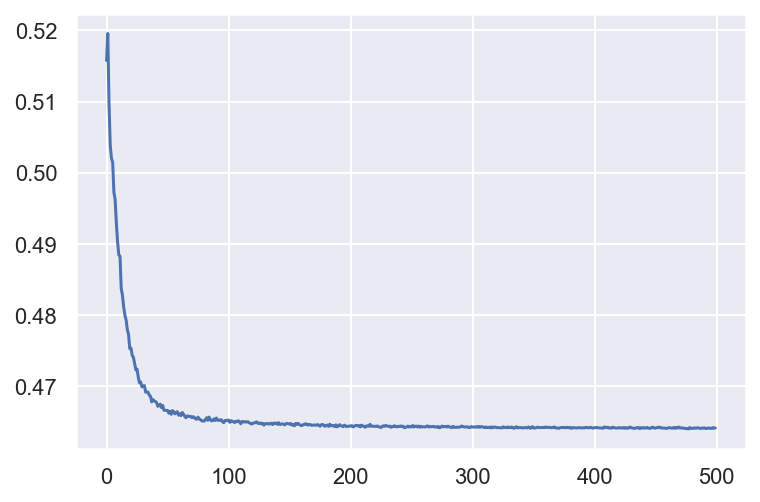

In [94]:
plt.plot(losses)

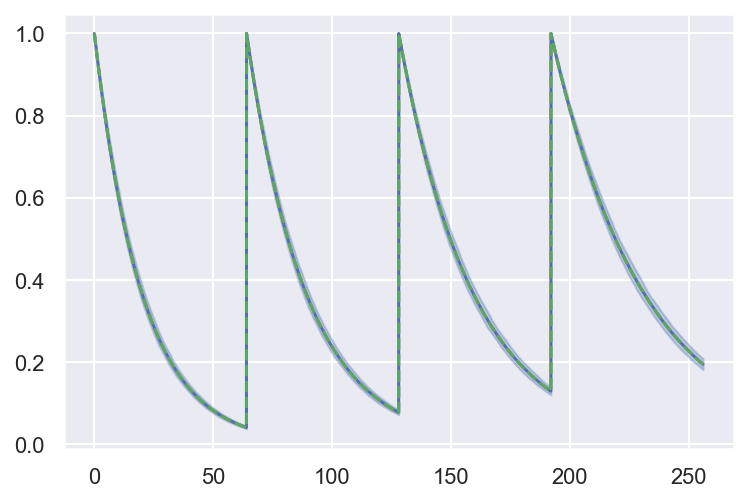

In [97]:
fill_alpha = 0.3

test_x = torch.from_numpy(x_input.astype(np.float32))
m_pred, f_pred = dm.pred(test_x)

test_x = test_x.numpy()
m_pred = m_pred.numpy()
f_pred = f_pred.numpy()

truth = m(x_input, theta)

f_mean = f_pred.mean(axis=0)
lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)

fig, ax = plt.subplots()

# GP confidence
h_conf = ax.fill_between(x_plot, upper, lower, color='C0', alpha=fill_alpha, label="Model + correction - Confidence")

# GP mean
h_mean, = ax.plot(x_plot, f_mean, label="Model + correction - Mean")

# Model
h_model, = ax.plot(x_plot, m_pred, color='C1', ls="--", label="Model alone")

# Ground truth
h_truth, = ax.plot(x_plot, truth, color='C2', ls="--", label="Ground truth")